<a href="https://colab.research.google.com/github/Junhojuno/keras-tutorial/blob/master/05_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### convolutional base (합성곱 층)의 일부를 재훈련시키자.
- convolutional base + fully connected layer 훈련

In [1]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('./gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ./gdrive


In [0]:
!cp gdrive/My\ Drive/master.zip ./

In [0]:
!unzip master.zip

In [0]:
!cp -r deep-learning-with-python-notebooks-master/datasets ./

In [5]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3))

Using TensorFlow backend.


58892288/58889256 [==============================] - 2s 0us/step


In [6]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### block5부터 tuning해보자
### 차례는 아래와 같다.
- 1. pre-training network위에 새로운 network를 추가(여기선 fully connected layer)
- 2. conv_base를 freezing(동결)한다.(conv_base는 가중치 업데이트 되지 않도록 한다.)
- 3. 새로 추가한 network를 훈련시킨다.
- 4. conv_base의 freezing을 일부만 해제한다.
- 5. 그 일부와 훈련한 새 network를 함께 훈련시킨다.

이전 실습한 내용을 저장해둘걸.... <br>
다시 새로운 network를 훈련시키도록 하자...ㅠ

In [0]:
import shutil, os

original_dataset_dir = "./datasets/cats_and_dogs/train/"

base_dir = "./datasets/cats_and_dogs_small"
os.mkdir(base_dir)

# 경로 및 디렉토리 생성
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# 훈련용 강아지/고양이 데이터셋 디렉토리 생성
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# 검증용 강아지/고양이 데이터셋 디렉토리 생성
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# 테스트용 강아지/고양이 데이터셋 디렉토리 생성
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

In [0]:
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)] # 처음 1000장 강아지 이미지를 train_dogs_dir로 복사
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    cp_src = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, cp_src)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000,1500)] # 다음 500장 강아지 이미지를 validation_dogs_dir로 복사
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    cp_src = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, cp_src)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1500,2000)] # 다음 500장 강아지 이미지를 test_dogs_dir로 복사
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    cp_src = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, cp_src)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)] # 처음 1000장 고양이 이미지를 train_cats_dir로 복사
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    cp_src = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, cp_src)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(1000,1500)] # 다음 500장 고양이 이미지를 validation_cats_dir로 복사
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    cp_src = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, cp_src)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(1500,2000)] # 다음 500장 고양이 이미지를 test_cats_dir로 복사
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    cp_src = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, cp_src)

In [9]:
# fully connected layer setting후 위 데이터로 훈련
from keras import models
from keras.layers import *
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [10]:
# 동결, freezing
# layer당 2개(weight 행렬, bias 벡터)
# VGG가 빠지면서 13개 layer가 빠지고, dense layer 2개만 남음
# 이걸 해주고 compile해줘야함!!

print("conv_base 동결 전 trainable 가중치 수 : ", len(model.trainable_weights))
conv_base.trainable = False
print("conv_base 동결 후 trainable 가중치 수 : ", len(model.trainable_weights))

conv_base 동결 전 trainable 가중치 수 :  30
conv_base 동결 후 trainable 가중치 수 :  4


In [11]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150,150), batch_size=20, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150,150), batch_size=20, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [12]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

hist = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30, validation_data=validation_generator, validation_steps=50, verbose=2)

Epoch 1/30
 - 29s - loss: 0.5965 - acc: 0.6940 - val_loss: 0.4669 - val_acc: 0.8240
Epoch 2/30
 - 25s - loss: 0.4933 - acc: 0.7800 - val_loss: 0.3958 - val_acc: 0.8360
Epoch 3/30
 - 25s - loss: 0.4386 - acc: 0.8055 - val_loss: 0.3516 - val_acc: 0.8550
Epoch 4/30
 - 25s - loss: 0.4053 - acc: 0.8110 - val_loss: 0.3175 - val_acc: 0.8790
Epoch 5/30
 - 25s - loss: 0.4016 - acc: 0.8200 - val_loss: 0.3127 - val_acc: 0.8700
Epoch 6/30
 - 25s - loss: 0.3755 - acc: 0.8340 - val_loss: 0.2896 - val_acc: 0.8800
Epoch 7/30
 - 25s - loss: 0.3660 - acc: 0.8370 - val_loss: 0.2861 - val_acc: 0.8830
Epoch 8/30
 - 25s - loss: 0.3494 - acc: 0.8535 - val_loss: 0.2945 - val_acc: 0.8740
Epoch 9/30
 - 25s - loss: 0.3321 - acc: 0.8495 - val_loss: 0.2777 - val_acc: 0.8820
Epoch 10/30
 - 24s - loss: 0.3326 - acc: 0.8560 - val_loss: 0.2717 - val_acc: 0.8910
Epoch 11/30
 - 25s - loss: 0.3263 - acc: 0.8535 - val_loss: 0.2652 - val_acc: 0.8920
Epoch 12/30
 - 25s - loss: 0.3290 - acc: 0.8480 - val_loss: 0.2602 - val_a

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

hist = model.fit_generator(train_generator, steps_per_epoch=100,epochs=100, validation_data=validation_generator, validation_steps=50)

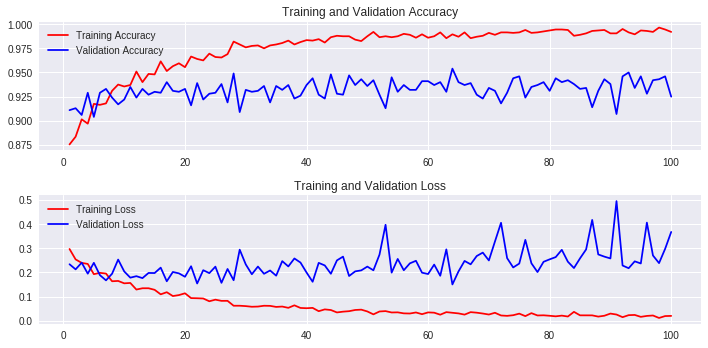

In [17]:
import matplotlib.pyplot as plt

epochs = range(1, len(hist.history['acc']) + 1)

plt.figure(figsize=(10,5))

plt.subplot(2,1,1)
plt.plot(epochs, hist.history['acc'], 'r-', label='Training Accuracy')
plt.plot(epochs, hist.history['val_acc'], 'b-', label='Validation Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")

plt.subplot(2,1,2)
plt.plot(epochs, hist.history['loss'], 'r-', label='Training Loss')
plt.plot(epochs, hist.history['val_loss'], 'b-', label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")

plt.tight_layout()
plt.show()

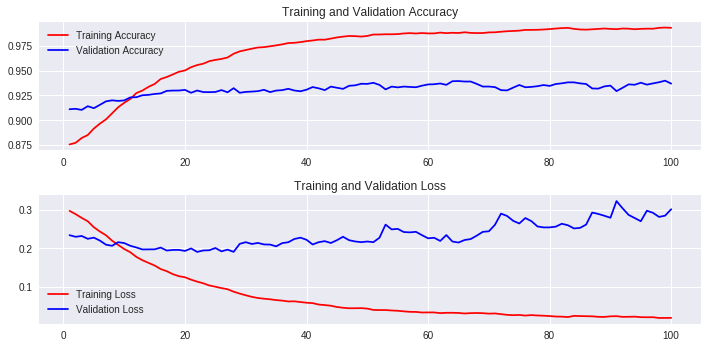

In [18]:
# Exponential Moving Average
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous*factor+point*(1-factor))
    else:
      smoothed_points.append(point)
      
  return smoothed_points


epochs = range(1, len(hist.history['acc']) + 1)

plt.figure(figsize=(10,5))

plt.subplot(2,1,1)
plt.plot(epochs,smooth_curve(hist.history['acc']), 'r-', label='Training Accuracy')
plt.plot(epochs, smooth_curve(hist.history['val_acc']), 'b-', label='Validation Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")

plt.subplot(2,1,2)
plt.plot(epochs, smooth_curve(hist.history['loss']), 'r-', label='Training Loss')
plt.plot(epochs, smooth_curve(hist.history['val_loss']), 'b-', label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")

plt.tight_layout()
plt.show()

성능은 올라갔는데...loss는 오히려 악화됨...?! <br>


In [19]:
test_generator = test_datagen.flow_from_directory(test_dir,target_size=(150,150), batch_size=20, class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print("test accuracy : ", test_acc)

Found 1000 images belonging to 2 classes.
test accuracy :  0.9309999930858612
